# MNIST Model Evaluation

Trained model can be found [here](https://www.kaggle.com/aditya08/25-million-images-0-99757-mnist)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import math
from glob import glob
import random
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, InputLayer
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import load_model, Model, Sequential

In [3]:
IMG_SIZE = 28
SAMPLE_SIZE = 100
BATCH_SIZE = 64
SEED = 42
LOAD_EMBEDDINGS = False
PATH_TO_EMBEDDINGS = "embeddings"

In [4]:
images = glob("../data/digits/train/*/*.png")

In [5]:
images = sorted(images, key=lambda x: x.split("/")[-2])

In [6]:
labels = [int(x.split("/")[-2]) for x in images]

In [7]:
print(f"# Total Images: {len(images)}")

# Total Images: 5672


## Create Testing Dataset

In [8]:
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, 1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image/255., tf.float32)
    return image, label

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.map(
    preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
def plot_samples(class_label, start, end):
    indexes = random.sample(range(start, end), 12)
    sample_images = [images[x] for x in indexes]
    sample_labels = [labels[x] for x in indexes]
    samples = dict(zip(sample_images, sample_labels))

    plt.figure(figsize=(9, 6))
    for idx, (path, label) in enumerate(samples.items()):
        ax = plt.subplot(3, 4, idx + 1)
        img = cv2.imread(path)
        plt.imshow(img.astype("uint8"))
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"Class {class_label}")
    plt.tight_layout()

In [11]:
lengths = [len(list(glob(f"../data/digits/train/{x}/*.png"))) for x in range(0, 10)]
lengths.insert(0, 0)
lengths = np.cumsum(lengths)

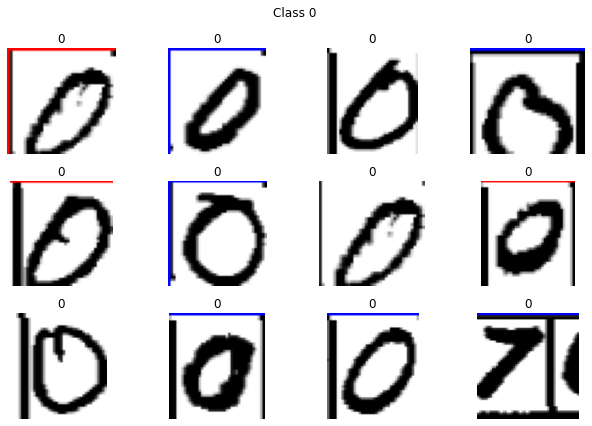

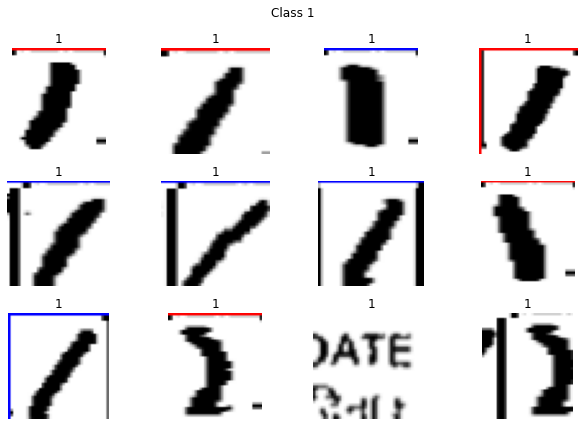

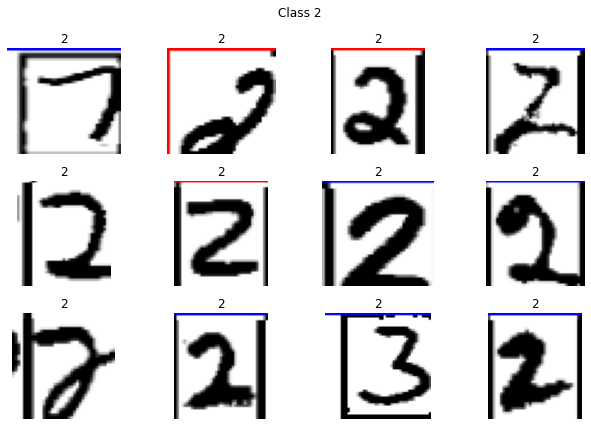

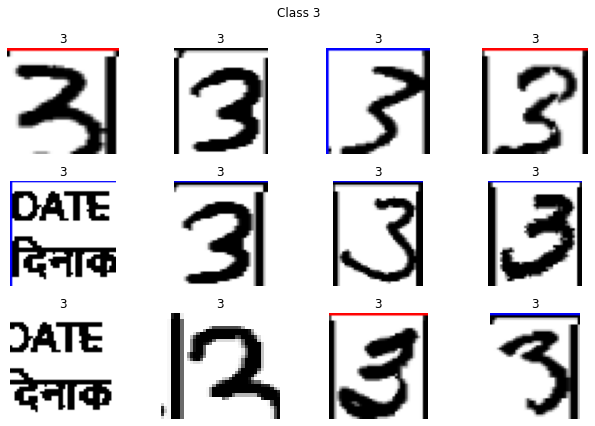

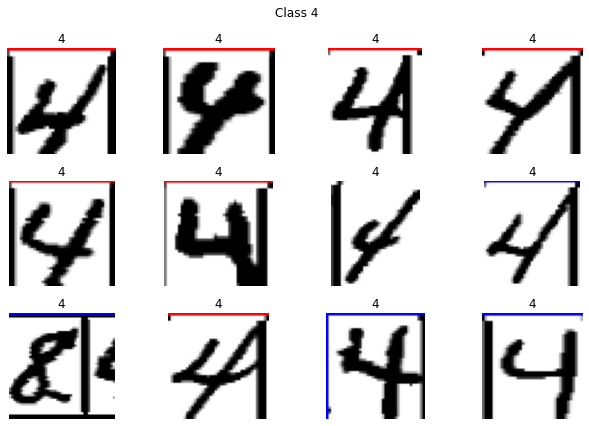

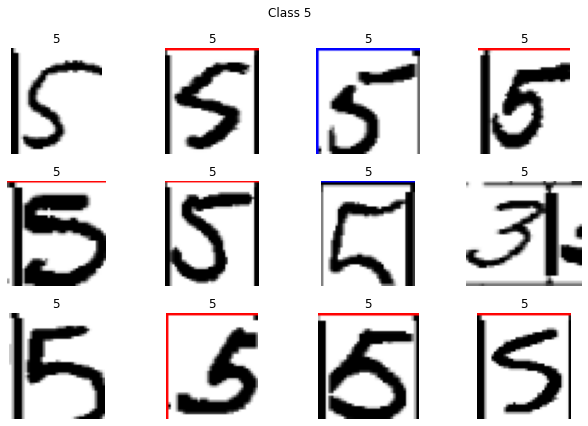

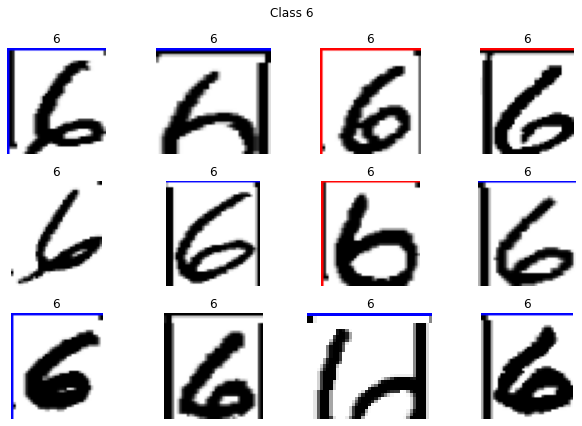

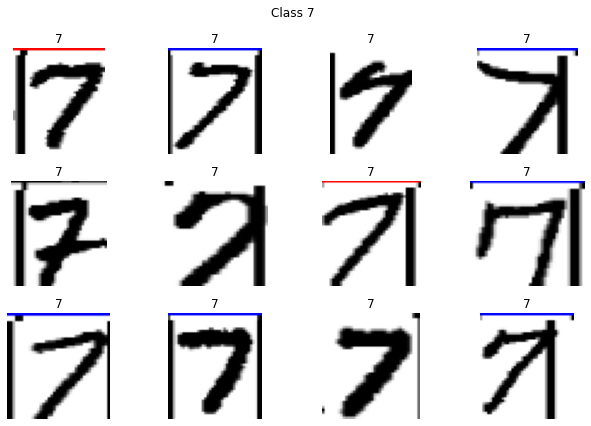

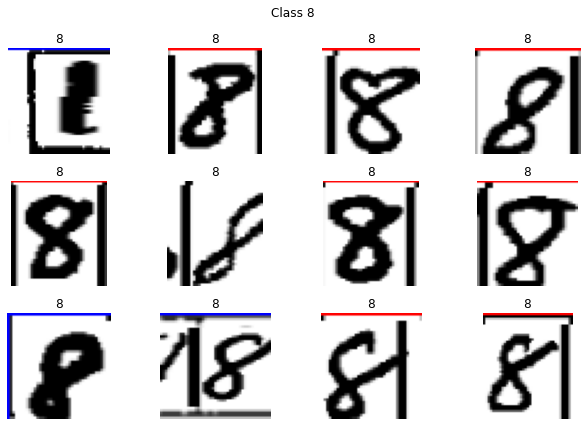

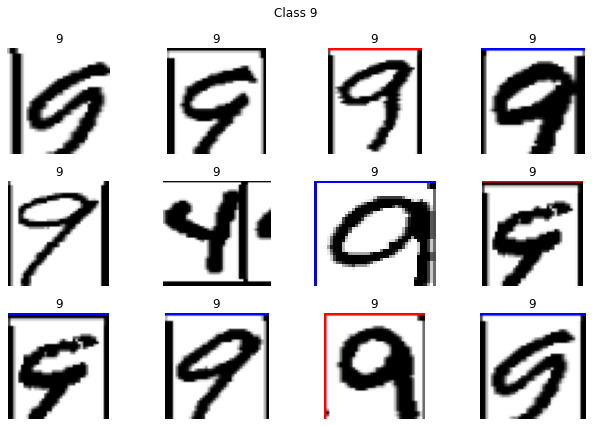

In [12]:
for idx, val in enumerate(range(10)):
    plot_samples(val, lengths[idx], lengths[idx+1])

## Inference

In [13]:
def get_mnist_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.load_weights("../data/external/model_0.h5")
    return model

In [14]:
model = get_mnist_model()

In [15]:
outputs = model.predict(dataset)

In [16]:
outputs.shape

(5672, 10)

In [17]:
predictions = np.argmax(outputs, axis=1)

In [18]:
def plot_samples(class_label, start, end):
    indexes = random.sample(range(start, end), 12)
    sample_images = [images[x] for x in indexes]
    pred_labels = [predictions[x] for x in indexes]
    samples = dict(zip(sample_images, pred_labels))

    plt.figure(figsize=(9, 6))
    for idx, (path, pred) in enumerate(samples.items()):
        ax = plt.subplot(3, 4, idx + 1)
        img = cv2.imread(path)
        plt.imshow(img.astype("uint8"))
        plt.title(f"Predicted: {pred}")
        plt.axis("off")
    plt.suptitle(f"Class {class_label}")
    plt.tight_layout()

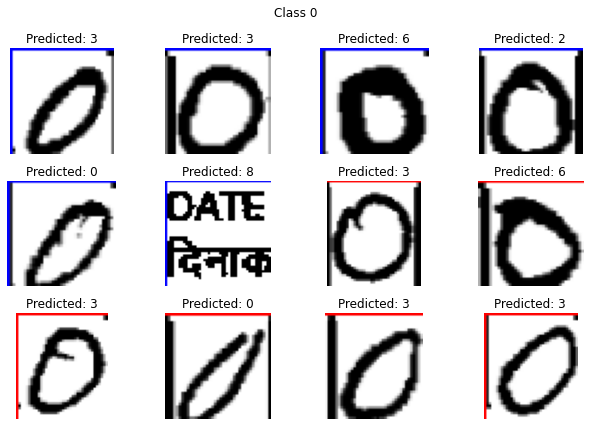

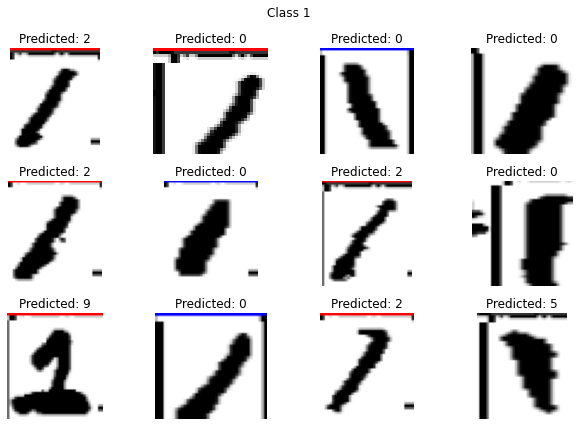

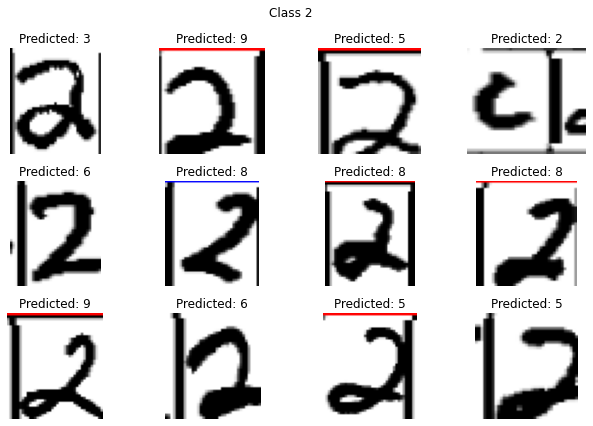

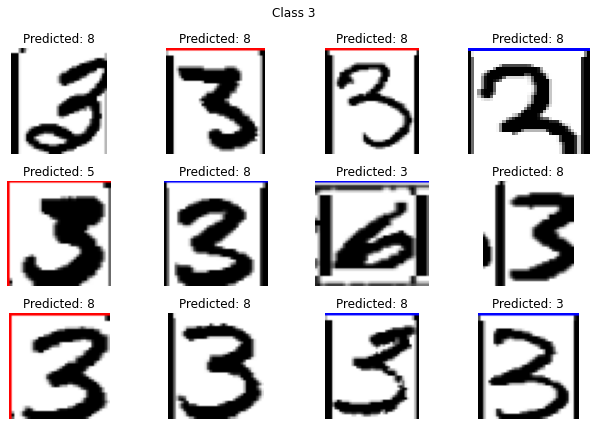

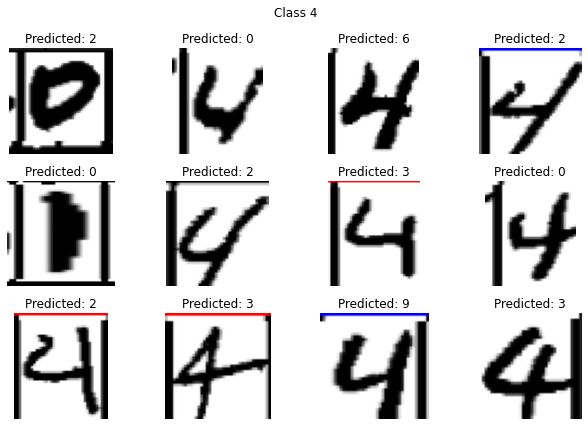

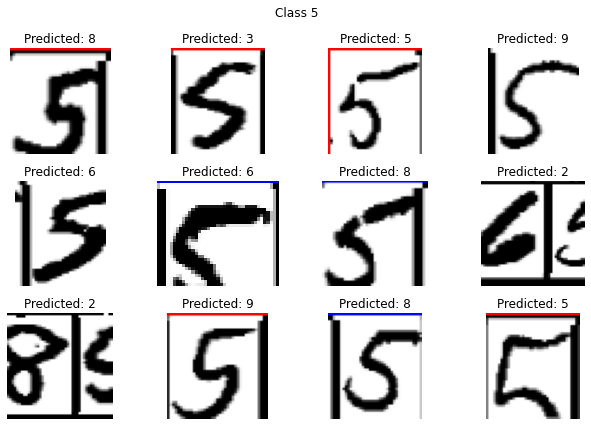

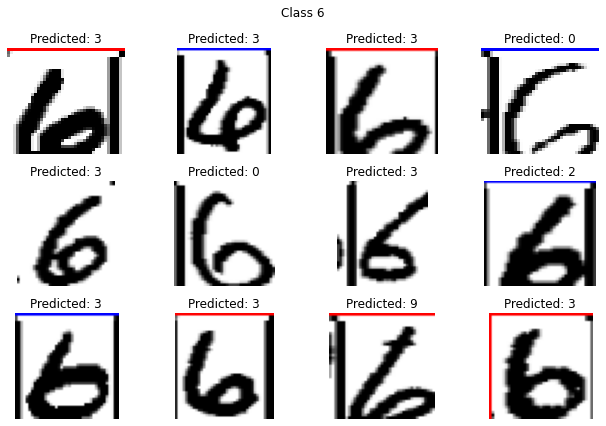

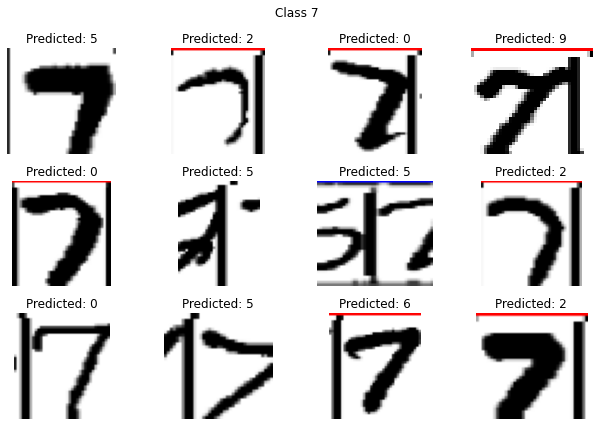

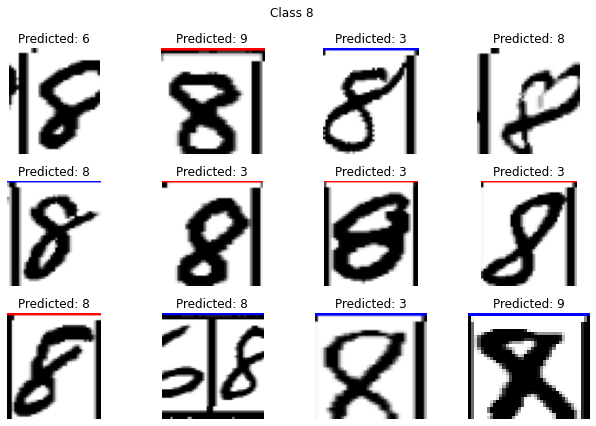

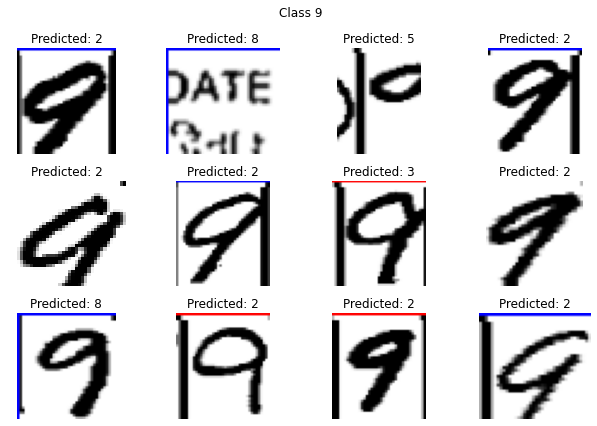

In [19]:
for idx, val in enumerate(range(10)):
    plot_samples(val, lengths[idx], lengths[idx+1])

In [20]:
print(f"Accuracy: {accuracy_score(labels, predictions)}")

Accuracy: 0.07968970380818054
